## Generative Adversarial Networks

<img src='gan1.png'>

The generator goal is to create images that fool the discriminator.

Phase 1 we train the discriminator labelling the fake generated images as 0, and real image as 1

<img src='gan2.png'>

Training phases:
1. Phase 1: Training Discriminator
2. Phase 2: Training Generator

Difficulties with GANs
1. Training Resources
2. Mode Collapse
3. Instability

In [45]:
import pandas as pd
import numpy as np

In [46]:
import matplotlib.pyplot as plt

In [47]:
%matplotlib inline

In [48]:
from tensorflow.keras.datasets import mnist

In [49]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

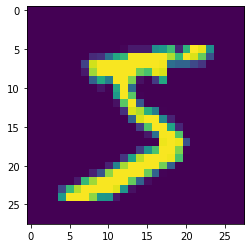

In [50]:
plt.imshow(X_train[0])

In [51]:
y_train == 0

array([False,  True, False, ..., False, False, False])

In [52]:
only_zeros = X_train[y_train==0]

In [53]:
only_zeros.shape

(5923, 28, 28)

In [54]:
X_train.shape

(60000, 28, 28)

In [55]:
# create the discriminator

In [56]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.models import Sequential

In [57]:
discriminator = Sequential()
discriminator.add(Flatten(input_shape=[28,28]))
discriminator.add(Dense(150, activation='relu'))
discriminator.add(Dense(100, activation='relu'))

#Final output layer
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

In [58]:
# create the generator

In [59]:
codings_size = 100

In [60]:
generator = Sequential()
generator.add(Dense(100, activation='relu', input_shape=[codings_size]))
generator.add(Dense(150, activation='relu'))
generator.add(Dense(784, activation='relu'))
generator.add(Reshape([28,28]))

In [61]:
GAN = Sequential([generator,discriminator])

In [62]:
discriminator.trainable = False

In [63]:
GAN.compile(loss='binary_crossentropy', optimizer='adam')

In [64]:
# setup the batches

In [65]:
batch_size = 32

In [66]:
# my_data = X_train
my_data = only_zeros

In [67]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [68]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [69]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [70]:
epochs = 1

In [71]:
GAN.layers

In [72]:
# Training loop

In [73]:
# Grab the seprate components
generator, discriminator = GAN.layers

# For every epcoh
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    # For every batch in the dataset
    for X_batch in dataset:
        i=i+1
        if i%100 == 0:
            print(f"\tCurrently on batch number {i} of {len(my_data)//batch_size}")
        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################
        
        # Create Noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # Generate numbers based just on noise input
        gen_images = generator(noise)
        
        # Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)
        
        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        
        # This gets rid of a Keras warning
        discriminator.trainable = True
        
        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        
        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################
        
        # Create some noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * batch_size)
        
        # Avois a warning
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("TRAINING COMPLETE")   

Currently on Epoch 1
	Currently on batch number 100 of 185
TRAINING COMPLETE


In [74]:
noise = tf.random.normal(shape=[10, codings_size])

In [75]:
noise.shape

TensorShape([10, 100])

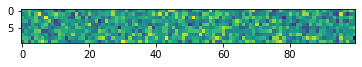

In [76]:
plt.imshow(noise)

In [77]:
images = generator(noise)

In [78]:
images.shape

TensorShape([10, 28, 28])

In [79]:
images[0]

<tf.Tensor: shape=(28, 28), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 

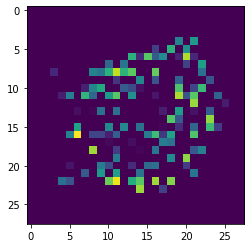

In [85]:
plt.imshow(images[7])

### Deep Convolutional GANs

They are typically used to attempt to build GANs better suited for image data.

In [86]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [87]:
X_train = X_train/255

In [88]:
X_train = X_train.reshape(-1, 28, 28, 1) * 2. -1.

In [89]:
X_train.min()

-1.0

In [90]:
X_train.max()

1.0

In [93]:
only_zeros = X_train[y_train==0]

In [98]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Reshape,Dropout,LeakyReLU,Flatten,BatchNormalization,Conv2D,Conv2DTranspose
from tensorflow.keras.models import Sequential

In [95]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 100

In [96]:
generator = Sequential()
generator.add(Dense(7 * 7 * 128, input_shape=[codings_size]))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                 activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                 activation="tanh"))


In [99]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3),
                        input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

In [100]:
GAN = Sequential([generator, discriminator])

In [101]:
discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False

In [102]:
GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [103]:
GAN.layers

In [104]:
batch_size = 32

In [105]:
# my_data = X_train
my_data = only_zeros

In [107]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [108]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [109]:
epochs = 20

In [110]:
# Grab the seprate components
generator, discriminator = GAN.layers

# For every epcoh
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    # For every batch in the dataset
    for X_batch in dataset:
        i=i+1
        if i%20 == 0:
            print(f"\tCurrently on batch number {i} of {len(my_data)//batch_size}")
        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################
        
        # Create Noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # Generate numbers based just on noise input
        gen_images = generator(noise)
        
        # Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)
        
        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        
        # This gets rid of a Keras warning
        discriminator.trainable = True
        
        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        
        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################
        
        # Create some noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * batch_size)
        
        # Avois a warning
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("TRAINING COMPLETE")            

Currently on Epoch 1
	Currently on batch number 20 of 185
	Currently on batch number 40 of 185
	Currently on batch number 60 of 185
	Currently on batch number 80 of 185
	Currently on batch number 100 of 185
	Currently on batch number 120 of 185
	Currently on batch number 140 of 185
	Currently on batch number 160 of 185
	Currently on batch number 180 of 185
Currently on Epoch 2
	Currently on batch number 20 of 185
	Currently on batch number 40 of 185
	Currently on batch number 60 of 185
	Currently on batch number 80 of 185
	Currently on batch number 100 of 185
	Currently on batch number 120 of 185
	Currently on batch number 140 of 185
	Currently on batch number 160 of 185
	Currently on batch number 180 of 185
Currently on Epoch 3
	Currently on batch number 20 of 185
	Currently on batch number 40 of 185
	Currently on batch number 60 of 185
	Currently on batch number 80 of 185
	Currently on batch number 100 of 185
	Currently on batch number 120 of 185
	Currently on batch number 140 of 185

In [111]:
noise = tf.random.normal(shape=[10, codings_size])

In [112]:
noise.shape

TensorShape([10, 100])

In [113]:
images = generator(noise)

In [114]:
single_image = images[0]

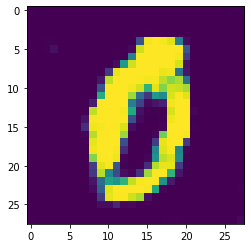

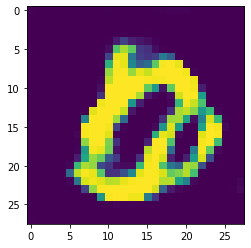

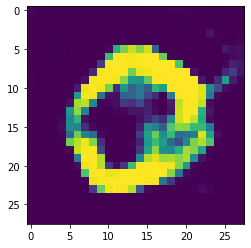

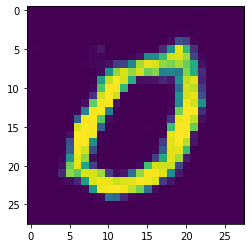

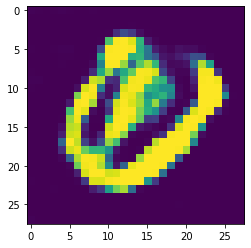

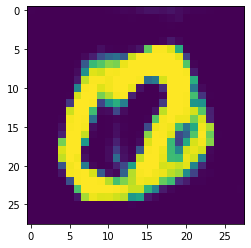

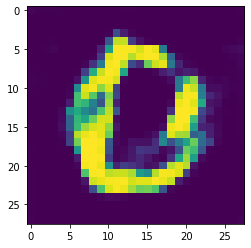

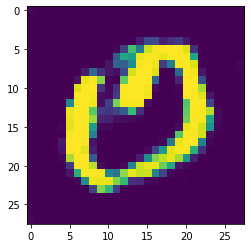

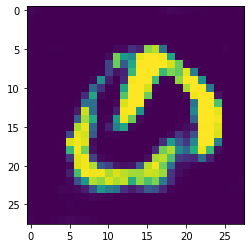

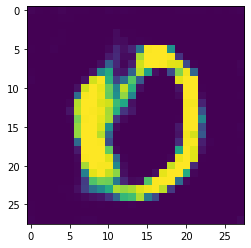

In [115]:
for image in images:
    plt.imshow(image.numpy().reshape(28,28))
    plt.show()